# <center>GAN for Generating Handwritten Digits </center>


---




<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >




In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 190167322.63it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42548540.16it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63100047.41it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23577387.09it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### How an Image is Represented

In [ ]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,:,:])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -

(tensor(-1.), tensor(1.))

Visualizing the pixel values

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


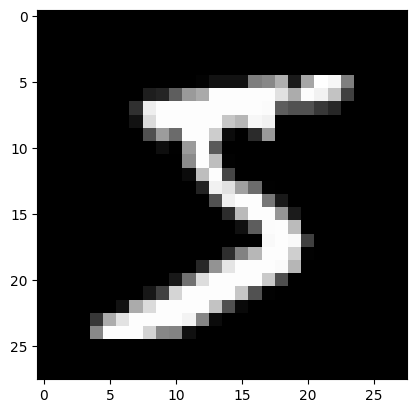

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

### Making 100 images into a batch


In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

In [ ]:
print(data_loader)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 5, 2, 7, 3, 0, 5, 3, 6, 1, 1, 8, 5, 9, 2, 7, 4, 7, 4, 1, 8, 7, 7, 9,
        2, 8, 5, 8, 1, 8, 9, 2, 1, 7, 9, 2, 1, 8, 7, 0, 1, 1, 1, 8, 1, 1, 5, 9,
        2, 0, 6, 7, 8, 2, 0, 5, 1, 2, 1, 0, 1, 4, 2, 5, 9, 9, 7, 5, 6, 3, 1, 6,
        3, 8, 1, 7, 9, 5, 7, 4, 5, 9, 1, 2, 3, 5, 8, 8, 4, 8, 4, 2, 4, 2, 2, 6,
        9, 1, 1, 5])


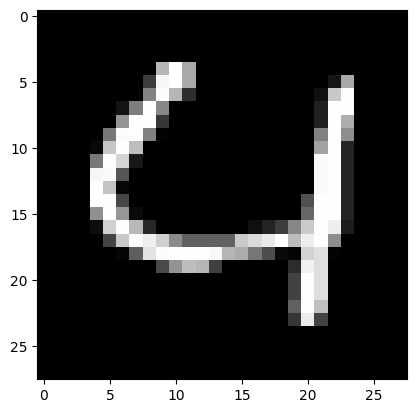

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break


We'll also create a `device` which can be used to move the data and models to a GPU, if one is available.

---


## Configuration

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## Discriminator

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network.  We'll treat each 28x28 image as a vector of size 784.

In [ ]:
image_size = 784
hidden_size = 256

We use the Leaky ReLU activation for the discriminator.

<img src="https://www.researchgate.net/publication/358306930/figure/fig2/AS:1119417702318091@1643901386378/ReLU-activation-function-vs-LeakyReLU-activation-function.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  -

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being fake i.e. generated.

Let's move the discriminator model to the chosen device.

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device);

## Generator

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >


Since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

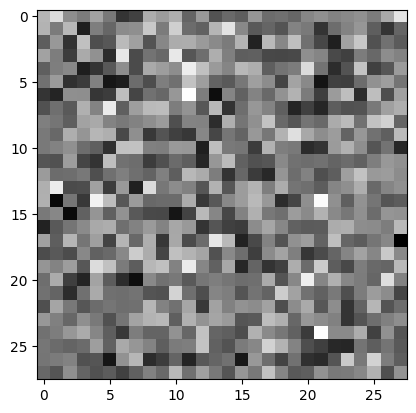

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

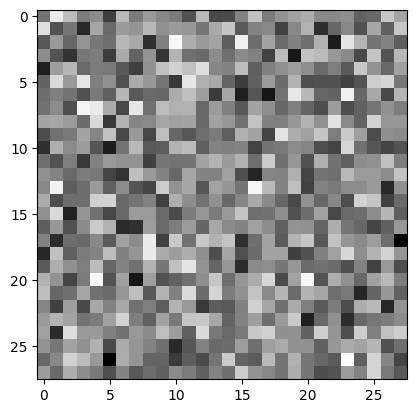

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

As one might expect, the output from the generator is basically random noise. Let's define a helper function which can save a batch of outputs from the generator to a file.

Let's move the generator to the chosen device.

In [ ]:
G.to(device);

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*rdBw0E-My8Gu3f_BOB6GMA.png" width="420" >

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

Let's define helper functions to reset gradients and  train the discriminator.

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`d_optimizer` only affects the `D.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.

Here's what this looks like in code.

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model


In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Saving a batch of real images that we can use for visual comparision while looking at the generated images.

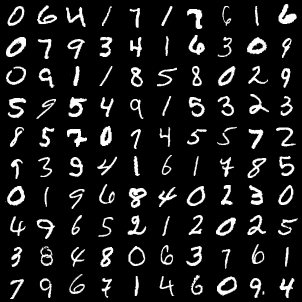

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


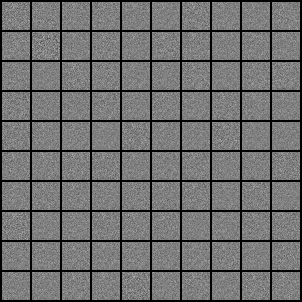

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Test : Proof of Work
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator.

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Saving images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0538, g_loss: 4.2686, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1832, g_loss: 5.7392, D(x): 0.93, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.0339, g_loss: 5.6342, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0480, g_loss: 5.7700, D(x): 0.99, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.0425, g_loss: 5.1988, D(x): 0.99, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.1510, g_loss: 4.3941, D(x): 0.94, D(G(z)): 0.07
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2003, g_loss: 4.0233, D(x): 0.94, D(G(z)): 0.10
Epoch [2/300], Step [400/600], d_loss: 0.1935, g_loss: 3.6431, D(x): 0.91, D(G(z)): 0.05
Epoch [2/300], Step [600/600], d_loss: 0.6589, g_loss: 3.2874, D(x): 0.83, D(G(z)): 0.15
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.9854, g_loss: 3.9940, D(x): 0.74, D(G(z)): 0.17
Epoch [3/300], Step [400/6

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Here's how the generated images look, after the 10th, 50th, 100th and 300th epochs of training.

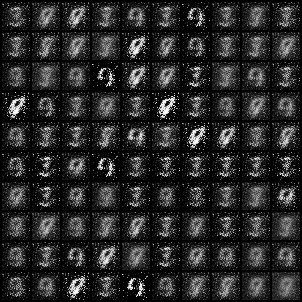

In [ ]:
Image('./samples/fake_images-0010.png')

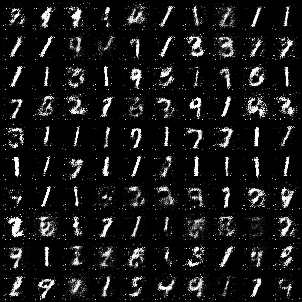

In [ ]:
Image('./samples/fake_images-0050.png')

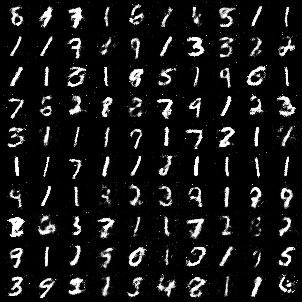

In [ ]:
Image('./samples/fake_images-0100.png')

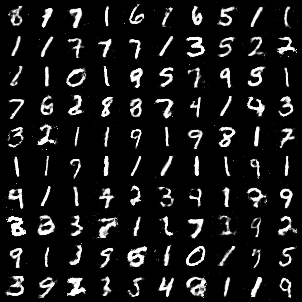

In [ ]:
Image('./samples/fake_images-0300.png')

## Statistics

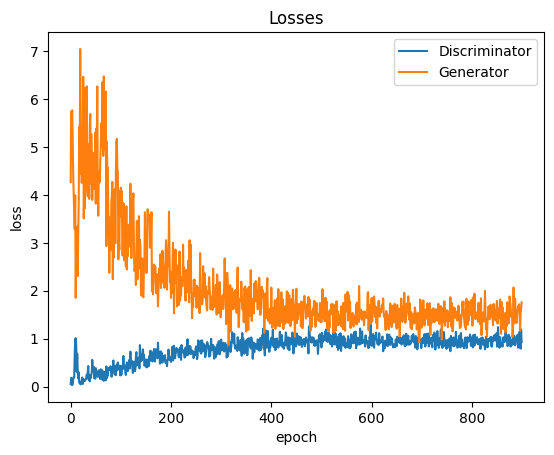

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

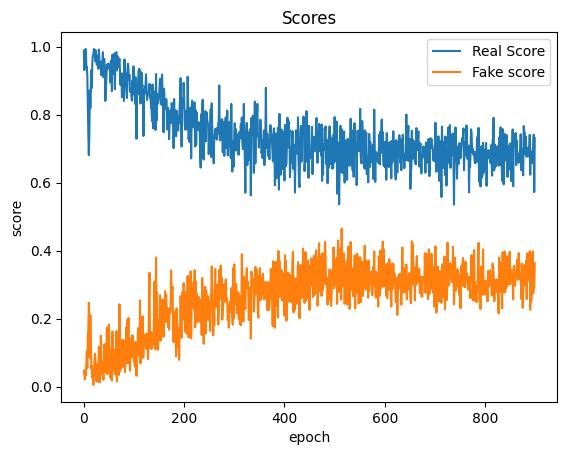

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');